# Project 2
## part 2

importing data and packages

In [1]:
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import datetime as dt
%matplotlib inline

pd.options.display.max_rows = 50
pd.options.display.max_columns = 999

sb.set()

dfTest = pd.read_csv("P2testing.csv")
dfTest["Date"] = pd.to_datetime(dfTest["Date"])

dfTrain = pd.read_csv("P2training.csv")
dfTrain["Date"] = pd.to_datetime(dfTrain["Date"])
dfTrain.columns = ['Date', 'AUD.USD', 'GBP.USD', 'CAD.USD', 'NLG.USD', 'FRF.USD',
       'DEM.USD', 'JPY.USD', 'CHF.USD']
                   

dfTrain.head()

,Date,AUD.USD,GBP.USD,CAD.USD,NLG.USD,FRF.USD,DEM.USD,JPY.USD,CHF.USD
0,1979-12-31,0.904404,0.450755,1.1684,1.9020,4.0175,1.7260,240.30,1.5950
1,1980-01-02,0.902527,0.445891,1.1658,1.8922,4.0150,1.7135,238.45,1.5775
2,1980-01-03,0.901388,0.446429,1.1703,1.8900,4.0100,1.7108,238.35,1.5720
3,1980-01-04,0.901713,0.447027,1.1687,1.8910,4.0250,1.7126,234.80,1.5755
4,1980-01-07,0.898311,0.442184,1.1694,1.8890,4.0090,1.7080,231.55,1.5700


In [2]:
dfTest.head()

,Date,AUD.USD,GBP.USD,CAD.USD,NLG.USD,FRF.USD,DEM.USD,JPY.USD,CHF.USD
0,1996-01-02,1.345352,0.642467,1.3577,1.6075,4.9025,1.4354,103.92,1.1573
1,1996-01-03,1.336005,0.644454,1.3530,1.6128,4.9180,1.4410,104.35,1.1605
2,1996-01-04,1.341742,0.646705,1.3541,1.6290,4.9625,1.4542,106.41,1.1737
3,1996-01-05,1.337793,0.644330,1.3573,1.6106,4.9230,1.4386,105.13,1.1605
4,1996-01-08,1.338151,0.645369,1.3609,1.6130,4.9370,1.4396,105.80,1.1631


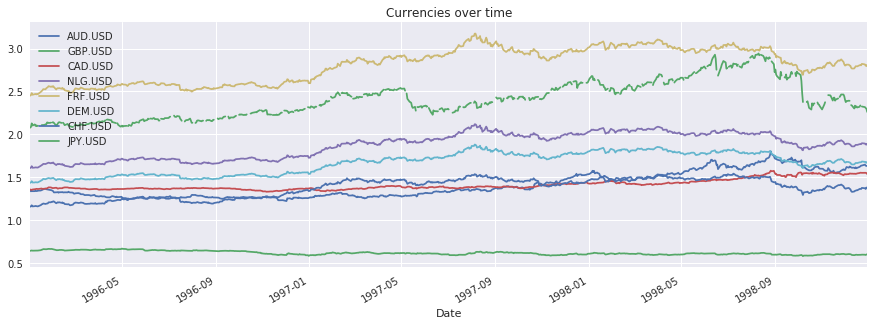

In [4]:
dfScaled = dfTest.drop("JPY.USD",axis=1)
dfScaled["JPY.USD"] = dfTest["JPY.USD"]/50
dfScaled["FRF.USD"] = dfScaled["FRF.USD"] /2
dfScaled.plot(x=dfScaled["Date"],figsize=(15,5),title="Currencies over time")
#plt.savefig("report/Images/CurrenciesPart2.eps", dpi = 1200)

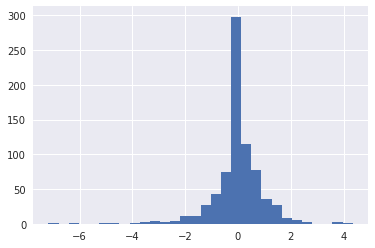

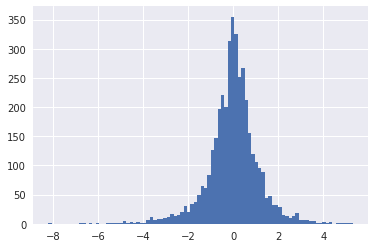

In [5]:
aux =  dfTest["JPY.USD"]- dfTest["JPY.USD"].shift()
aux[aux.isnull()] = 0
plt.hist(aux,bins=30)
plt.show()

aux =  dfTrain["JPY.USD"]- dfTrain["JPY.USD"].shift()
aux[aux.isnull()] = 0
plt.hist(aux,bins = 90)
plt.show()

The first order difference has a distribution with mean close to zero and bell shape

amount of data available Vs amount to predict

In [6]:
print "non NAN rows: " + `sum(dfTest['JPY.USD']>0)`
print "to predict: " + `sum(dfTest['JPY.USD'].isnull())`

non NAN rows: 680
to predict: 75


Before day prediction:

In [7]:
pred = dfTest["JPY.USD"].shift()
pred[0] = dfTrain['JPY.USD'][len(dfTrain['JPY.USD'])-1]

for i in range(len(pred)):
    if np.isnan(pred[i]):
        pred[i] = pred[i-1]

print np.mean((pred- dfTest["JPY.USD"])**2)

##### Saving 

text_file = open("DayBeforePrediction.txt", "w")

text_file.write('A0176509W\n')

for item in pred:
    text_file.write("%s\n" % item)
    
text_file.close()

1.17765176471


Preprocessing

In [8]:
#initial date
d0 = pd.to_datetime("1979-12-30")

#creating a function that does the preprocessing for organization purposes
def datasetTransformation(dfRaw, k = 5):
    data = pd.DataFrame()
    #Date feature (converting to integer)
    data["Date"] = (dfRaw['Date'] - d0)  / np.timedelta64(1,'D')
    
    #Dummy Variables for weekdays
    weekday = dfRaw['Date'].dt.weekday_name
    data["Mon"] = [1 if day else 0 for day in weekday == "Monday"   ]
    data["Tue"] = [1 if day else 0 for day in weekday == "Tuesday"  ]
    data["Wed"] = [1 if day else 0 for day in weekday == "Wednesday"]
    data["Thu"] = [1 if day else 0 for day in weekday == "Thursday" ]
#    data["Fri"] = [1 if day else 0 for day in weekday == "Friday"   ]
    
    #We use the last k day's data from all currencies
    for i in range(1,k+1):
        for currency in ['JPY','AUD','GBP','CAD','NLG','FRF','DEM','CHF']:
            data[currency +`i`] = dfRaw[currency + '.USD'].shift(i)
    
    data['Target'] = dfRaw["JPY.USD"]
    return data



In [9]:
dataTrain = datasetTransformation(dfTrain,k = 2)
dataTest = datasetTransformation(dfTest,k = 2)
dataTest.head()

,Date,Mon,Tue,Wed,Thu,JPY1,AUD1,GBP1,CAD1,NLG1,FRF1,DEM1,CHF1,JPY2,AUD2,GBP2,CAD2,NLG2,FRF2,DEM2,CHF2,Target
0,5847.0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.92
1,5848.0,0,0,1,0,103.92,1.345352,0.642467,1.3577,1.6075,4.9025,1.4354,1.1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.35
2,5849.0,0,0,0,1,104.35,1.336005,0.644454,1.3530,1.6128,4.9180,1.4410,1.1605,103.92,1.345352,0.642467,1.3577,1.6075,4.9025,1.4354,1.1573,106.41
3,5850.0,0,0,0,0,106.41,1.341742,0.646705,1.3541,1.6290,4.9625,1.4542,1.1737,104.35,1.336005,0.644454,1.3530,1.6128,4.9180,1.4410,1.1605,105.13
4,5853.0,1,0,0,0,105.13,1.337793,0.644330,1.3573,1.6106,4.9230,1.4386,1.1605,106.41,1.341742,0.646705,1.3541,1.6290,4.9625,1.4542,1.1737,105.80


In [10]:
dataTrain.head()

,Date,Mon,Tue,Wed,Thu,JPY1,AUD1,GBP1,CAD1,NLG1,FRF1,DEM1,CHF1,JPY2,AUD2,GBP2,CAD2,NLG2,FRF2,DEM2,CHF2,Target
0,1.0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.30
1,3.0,0,0,1,0,240.30,0.904404,0.450755,1.1684,1.9020,4.0175,1.7260,1.5950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.45
2,4.0,0,0,0,1,238.45,0.902527,0.445891,1.1658,1.8922,4.0150,1.7135,1.5775,240.30,0.904404,0.450755,1.1684,1.9020,4.0175,1.7260,1.5950,238.35
3,5.0,0,0,0,0,238.35,0.901388,0.446429,1.1703,1.8900,4.0100,1.7108,1.5720,238.45,0.902527,0.445891,1.1658,1.8922,4.0150,1.7135,1.5775,234.80
4,8.0,1,0,0,0,234.80,0.901713,0.447027,1.1687,1.8910,4.0250,1.7126,1.5755,238.35,0.901388,0.446429,1.1703,1.8900,4.0100,1.7108,1.5720,231.55


Train MSE: 1.3275162709826263
Test  MSE: 1.1516445909817579


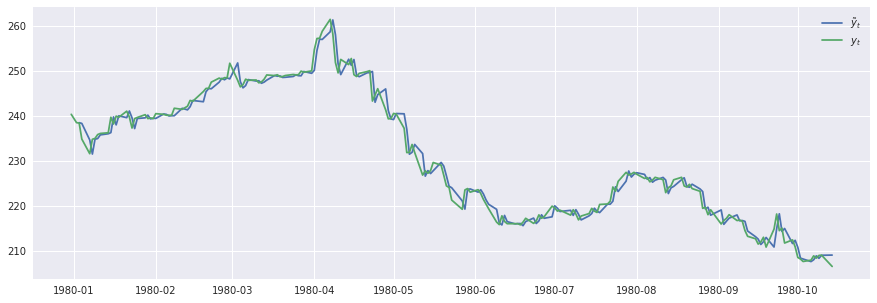

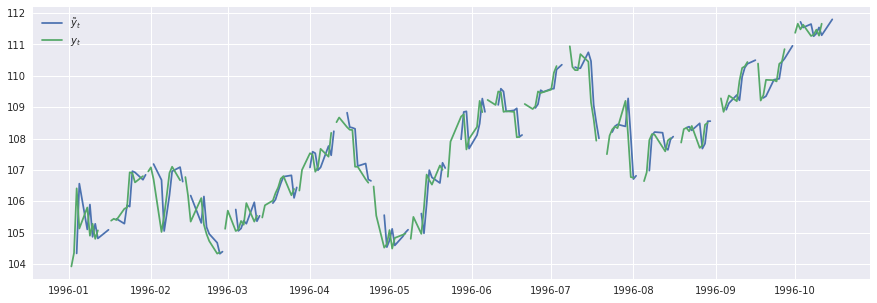

In [12]:
formula='Target ~ JPY1 + AUD1 + GBP1 + CAD1 + NLG1 + FRF1 + DEM1 + CHF1'
formula=formula+'+JPY2 + AUD2 + GBP2 + CAD2 + NLG2 + FRF2 + DEM2 + CHF2'

lmfit = smf.ols(formula, data = dataTrain).fit()

lmfit.summary()

pred = lmfit.predict(dataTrain.drop(['Target', 'Mon','Tue','Wed','Thu'],axis = 1))
print "Train MSE: " + `lmfit.mse_resid`

plt.figure(figsize=(15,5))
plt.plot(dfTrain['Date'][0:200],             pred[0:200])
plt.plot(dfTrain['Date'][0:200],dfTrain['JPY.USD'][0:200])
plt.legend(["$\~{y}_t$","$y_t$"])
#plt.savefig("report/Images/LinRegMultiregressionTrain.eps", dpi = 1200)

pred = lmfit.predict(dataTest.drop(['Target', 'Mon','Tue','Wed','Thu'],axis = 1))
print "Test  MSE: " + `np.mean((pred-dataTest['Target'])**2)`

plt.figure(figsize=(15,5))
plt.plot(dfTest['Date'][0:200],             pred[0:200])
plt.plot(dfTest['Date'][0:200],dfTest['JPY.USD'][0:200])
plt.legend(["$\~{y}_t$","$y_t$"])
#plt.savefig("report/Images/LinRegMultiregressionTest.eps", dpi = 1200)


Last approach: for each value on the testing set, we fit a regression model with all (or most) values before it

In [14]:
k = 4018
M = len(dfTrain['Date'])

data = dfTrain.copy()
data = data.loc[len(data['Date']) - k:]

newdata = dfTest.copy()

newdata['IndexTemp'] = [M + i for i in range(len(dfTest['Date']))]
newdata =newdata.set_index('IndexTemp')

Dmin = newdata.index.min()

data = data.append(newdata)

data = datasetTransformation(data, k =2)
data = data.drop(['Date', 'Mon','Tue','Wed','Thu'],axis = 1)

predictions = []

for i in range(len(dfTest['Date'])):
    #take all data before the given date (i + Dmin). we train over those
    dataTemp = data.loc[i+Dmin-k-1:i+Dmin-1]
    #take the line of the day we want to predict
    targ = data.drop('Target',axis=1)
    targ = targ.loc[i+Dmin:i+Dmin]
    
    lmfit = smf.ols(formula, data = dataTemp).fit()

    pred = lmfit.predict(targ)
    predVal =  pred.loc[i+Dmin]
    
    predictions.append(predVal)
    
    if np.isnan(data['Target'][i+Dmin]):
        #data['Target'][i+Dmin] = predVal
        data['JPY1'][i+Dmin + 1] = predVal
        data['JPY2'][i+Dmin + 2] = predVal
print np.mean((predictions - dfTest['JPY.USD'])**2)
len(predictions)
####### Saving on file
text_file = open("MultipleRegComplexPred.txt", "w")

text_file.write('A0176509W\n')

for item in predictions:
    text_file.write("%s\n" % item)
    
text_file.close()

1.17435829765


computing correlations

In [13]:
cor = []
cordiff1= []
cordiff2= []
corrdiffPast2 = []
corrdiffPast3 = []
corrdiffPast4 = []
corrdiffPast5 = []
for currency in ['JPY','AUD','GBP','CAD','NLG','FRF','DEM','CHF']:
    JPY = dfTrain['JPY.USD']
    CUR = (dfTrain[currency + '.USD']).shift()
    CUR[0] = CUR[1]
    
    diffJPY = (JPY - JPY.shift(1))
    diffJPY[0] = 0
    diffCur = CUR - CUR.shift(1)
    diffCur[0] = 0

    diffCurPast2 = diffCur.shift()
    diffCurPast2[0]=0
    
    diffCurPast3 = diffCurPast2.shift()
    diffCurPast3[0]=0
    
    diffCurPast4 = diffCurPast3.shift()
    diffCurPast4[0]=0
    
    diffCurPast5 = diffCurPast4.shift()
    diffCurPast5[0]=0
    
    diffJPY2 = JPY + 2*JPY.shift(1) - JPY.shift(2)
    diffJPY2[0] = 0
    diffJPY2[1] = 0
    diffCur2 = CUR - 2*CUR.shift(1) + CUR.shift(2)
    diffCur2[0] = 0
    diffCur2[1] = 0
    
    cor1 = np.corrcoef(JPY,CUR)
    cor2 = np.corrcoef(diffJPY,diffCur)
    cor3 = np.corrcoef(diffJPY2,diffCur2)
    
    cor.append(cor1[0][1])
    cordiff1.append(cor2[0][1])
    cordiff2.append(cor3[0][1])
    
    corrdiffPast2.append(np.corrcoef(diffJPY,diffCurPast2)[0][1])
    corrdiffPast3.append(np.corrcoef(diffJPY,diffCurPast3)[0][1])
    corrdiffPast4.append(np.corrcoef(diffJPY,diffCurPast4)[0][1])
    corrdiffPast5.append(np.corrcoef(diffJPY,diffCurPast5)[0][1])

print np.transpose(cor)
print np.transpose(cordiff1)
print np.transpose(cordiff2)

print corrdiffPast2
print corrdiffPast3
print corrdiffPast4
print corrdiffPast5

[ 0.9997789  -0.60914623  0.09065097 -0.1319213   0.8371372   0.54356257
  0.8556803   0.88232618]
[ 0.03109065  0.00212791 -0.00515587  0.00622544  0.01492235  0.01743243
  0.00898792  0.02131087]
[ 0.0069282   0.00117993  0.00350315  0.00111801  0.00445561  0.00414549
  0.00460195  0.00455784]
[0.0152171531520884, 0.0016243463843799832, 0.002451427837847324, -0.0082483838931696751, 0.0035268650507369382, 0.0064902173846255072, 0.0067675190025836942, 0.0098482362327103751]
[0.046604059696631561, 0.030081838499777542, 0.014895369045576656, 0.0051663431408335188, 0.050341187573605013, 0.041143943886338213, 0.046190883052818925, 0.040436209774093158]
[0.023044521508304081, 0.015049303797268843, 0.003348026355346265, 0.0068539791785772073, 0.0089738495354093825, 0.0062239551125917716, 0.0063670947239932805, 0.011974834371140658]
[0.031207390754108274, 0.0024877236012527722, 0.024779905974903718, 0.030012970723659448, 0.02485182874121988, 0.032091518123582907, 0.032704613134206778, 0.03651